# Natural Language Processing basics with the Python Natural Language Toolkit (NLTK)

Goal: Understand the fundamentals of NLP through a text classification machine learning case study - Given an SMS text, classify it as spam or not spam. I have generated this code to summarize my learnings from the online tutorial - NLP for Python Machine Learning Essential Training by Derek Jedamski


### Download NLTK package in Python

In [54]:
# nltk.download()
import nltk
import pandas as pd
from matplotlib import pyplot 
import numpy as np
import string
import re #-- regex
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.model_selection import train_test_split 



In [55]:
#gives list  of various functions in nltk package 
# dir(nltk)

# Import Text File

In [56]:
# tip - following approach of reading file can be useful when the file format and content is unknown. 
#meaning - we don't know if the data is tab seperated or comma seperated for example 

#we will first explore the content of the file and then decide the best way to split the labels and text for analysis 

#Note - since this is a tab seperated file, there is an easier way to ingest this file described later

rawData = open('/kaggle/input/smsspamcollection/SMSSpamCollection.tsv').read()

#print first 500 characters 
print(rawData[0:500])


#everything is read as a big string  
# you see  a pattern with \t for tab and \n for new line 
print("Printing data type")
print((type(rawData)))

#convert the string into list such that the outcome (spam/ ham) and the coresponding texts are elements of the list 

#to achieve this, replace \t with \n so now we have new line after ham or spam 
print("Printing data when tab is replaced by newline")
print(rawData.replace('\t', '\n')[0:500])

#then use string function split('\n') to create a list where each element represents a line 
#so create a list called parseData 
parseData = rawData.replace('\t', '\n').split('\n')
print("Printing the string to list output \n")
print(parseData[0:5])

ham	I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	Nah I don't think he goes to usf, he lives around here though
ham	Even my brother is not like to speak with me. They treat me like aid
Printing data type
<class 'str'>
Printing data when tab is replaced by newline
ham
I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
spam
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham
Nah I don't think he goes to usf, he lives around here

In [57]:
#Further split the list into labels (spam/ ham) and text 

#since every other element starting from 0 is the label ham or spam we separate it 
#middle index is blank since we want to track all elements from 0th position till end 
labelList = parseData[0::2]
print(labelList[0:5])
textList = parseData[1::2]
print(textList[0:3])

['ham', 'spam', 'ham', 'ham', 'ham']
["I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.", "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", "Nah I don't think he goes to usf, he lives around here though"]


In [58]:
print(f'Printing the length of labels list {len(labelList)}')
print(f'Printing the length of text list {len(textList)}')

#we expect that the length of boths  lists  should be same but labelList has one extra element 
#explore this issue further 

Printing the length of labels list 5571
Printing the length of text list 5570


In [59]:
#likely there is an extra element  towards the end of the text file 
#so check last 5 elements 
print(labelList[-5:])  # this says start from end and print 5 elements backwards  

#Observation - There is a blank space towards the end of this  list 

['ham', 'ham', 'ham', 'ham', '']


In [60]:
#so exclude the last blank element and use these lists  to creare a dataframe 

df = pd.DataFrame({
    'label': labelList[:-1], # this says print all but  the last one represented by  -1
    'text_body' : textList
})
df.head()

#Now that we have a dataframe with labels and corresponding text, let's proceed with data exploration
#and text cleaning

,label,text_body
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [61]:
# # # short cut to import in above format
# df = pd.read_csv('/kaggle/input/smsspamcollection/SMSSpamCollection.tsv', sep = '\t', header = None)
# df.head()
# # then you can change column names 
# df.columns = {'labels', 'text_body'}
# df.head()

In [62]:
#Data  Exploration 

#what is dataframe size 
print(df.shape)

#how many hams and spams in the data 
print(df.groupby('label').count())

#missing data 
df.isnull().sum()

#Observation - There are no missing values and only 746 SMS are spam 

(5570, 2)
       text_body
label           
ham         4824
spam         746


label        0
text_body    0
dtype: int64

In [63]:
# % of spam records 
spam_percentage = (len(df[df['label'] == 'spam']) / len(df)) * 100

print(f"Percentage of spam records: {spam_percentage:.2f}%")

Percentage of spam records: 13.39%


# Text Cleaning using NLTK package 

Goal of text cleaning is to distill the information in the text in few keywords. This enhances the text analysis process and is computationally efficient 

Steps involved:
1. Removing punctuations using Regex 

2. Tokenize - split the string of words into list of words . split when we find not word like white space 

3. Removing stopwords - Stopwords are words that are frequently used in sentences but carry neutral sentiment. For example, a, an, the, where, with
Since stopwords don't add little to no meaning, they can be filtered out. 

4. Stemming - converting variations of words to root word. For example grows and growing are converted to grow as their root word. There are various stemming functions, here we use PorterStemmer 

5. Vectorization - in this step the list of words we get from stemming step are converted into a matrix. This is a rows and columns representation of the data such that rows still represent individual SMS. The columns are the distinct words that appear in all the messages in the data set. 
For each row, we then get the count of occurances of each word/ column in that SMS. 
This matrix is also called Document Term Matrix and this process of vectorization is called count vectorization.

There are also other types of vectorization methods like N-gram and TF-IDF term frequency and inverse doc frequency 
which are also explored in this notebook. 

In [64]:

# remove punctuations using regex your own code but there will be some function in nltk library

print(string.punctuation)
def remove_punc(x):
    x_no_punc = "".join([char for char in x if char not in string.punctuation])
    return x_no_punc

df['text_clean'] = df['text_body'].apply(lambda x: remove_punc(x))
df.head()
    

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,label,text_body,text_clean
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL


In [65]:
#tokenize - split the string of words into list of words . split when we find not word like white space 
# use regex for it 

def tokenize(x): 
    token = re.split('\W+', x)
    return token 
df['token'] = df['text_clean'].apply(lambda x: tokenize(x.lower()))
df.head()

,label,text_body,text_clean,token
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]"


In [66]:
#explore nltk stopwords package 


stopword = stopwords.words('english')
#get first 500 stop words 
# stopword[0:500]
#get  every 25th stop word
print(stopword[0:500:25])

def rem_stopwords(token):
    token_no_stopwords = [word for word in token if word not in stopword]
    return token_no_stopwords

df['token_no_stopwords'] =  df['token'].apply(lambda x: rem_stopwords(x))
df.head()

['i', 'herself', 'been', 'with', 'here', 'very', 'doesn', 'won']


,label,text_body,text_clean,token,token_no_stopwords
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]"


In [67]:
#stemming #converting variations of words to root word -- see example below
ps = nltk.PorterStemmer()
# dir(ps) -- will list all functions withen ps. we will use the stem function 
print(ps.stem('growing'))
print(ps.stem('grows'))
print(ps.stem('growen'))

print(ps.stem('run'))
print(ps.stem('running'))
print(ps.stem('runner'))

print(ps.stem('meanness'))
print(ps.stem('meaning'))


print(ps.stem('week'))
print(ps.stem('weekly'))
print(ps.stem('wkly'))



grow
grow
growen
run
run
runner
mean
mean
week
weekli
wkli


In [68]:
#apply stemming on our data set this will reduce words to their root word and save computation resources later 
def stemmed(token):
    token_stem = [ps.stem(word) for word in token]
    return token_stem

df['token_stemmed'] =  df['token_no_stopwords'].apply(lambda x: stemmed(x))
df.head()

,label,text_body,text_clean,token,token_no_stopwords,token_stemmed
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr..."
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,..."
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]"


In [69]:

# #lemmatizer
# #similar to stemming, reduces the words to root word but uses dictionaty meaning and context into account 
#so it is more accurate than stemming but more processing time needed 
#stemming will chop the end words so less accurate but faster

# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# lemmatizer.lemmatize('going', wordnet.VERB)
# #this code is  having some issues check later and check advanced ways  to reduce words to their root word 


In [70]:
#once you have the tokens clean from a text next step is  vectorizations 

# basically create numeric matrix of the tokens to run ML algo for prediction 
# so rows will still be each record of text in your dataset 
# columns will be distinct words that appear in your document 
# and now for each row get the number of times (frequency) that word appears in the text 
# this is also called document term matrix 

#there are 3 ways of vectorization 
#1. count vectorization as decribed above. Below is function implementing this method. 

#We will use CountVectorize from sklearn which needs input tokens 
#or you can also input text along with a pre-processing/ text cleaning function which will be first applied to text 
#the output tokens will then be used to create count vectors 


#The token_text function below is another way to do text pre-processing all in one function 
#i.e. remove punctuations, convert to tokens, remove stopwords and perform stemming in that order 

def token_text(text):
    
    x_no_punc = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', x_no_punc)
    token_cleaned = [ps.stem(word) for word in tokens if word not in stopword]
    return token_cleaned


#instantiate CountVectorier if you have a  cleaning function (like token_text()) that you want to run before the count vectorizer

# pass it as analyzer = function name 
count_vect = CountVectorizer(analyzer = token_text)
#fit function of Count Vectorizer will only fit i.e. learn vectors from  your data 
#so to create vectorized data  use fit_transform 
    
X_counts = count_vect.fit_transform(df['text_body'])
print(X_counts.shape)
print(count_vect.get_feature_names_out())


(5570, 8337)
['' '0' '008704050406' ... 'ü' 'üll' '〨ud']


In [71]:
X_counts
#sparse matrix have lot of 0 values so for storage efficiency only location of non zero values are stored 

<5570x8337 sparse matrix of type '<class 'numpy.int64'>'
	with 55740 stored elements in Compressed Sparse Row format>

In [72]:
#to view it as regulat matrix where 0s are also stored convert to array
X_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [73]:
#convert this array to dataframe where column  name represents the distinct words in the data set
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.head()
X_counts_df.columns = count_vect.get_feature_names_out() 
X_counts_df.head()

,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#N-grams is another vectorization method where the columns in doc term metrics will not be every single word rather it will be N adjecent words 
#example - your string is - NLP is an interesting topic and you go for N = 2 which is bi-gram then your columns will be 'NLP is', 'is an', 'an interesting' and so on 
#choice of N is important N = 3 is tri gram 

#the N gram function needs a string input unlike count vector which needs list of tokens 
#so first edit below function to pass clean string 

def token_text_clean(text):
    
    x_no_punc = "".join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', x_no_punc)
    token_cleaned = [ps.stem(word) for word in tokens if word not in stopword]
    clean_text = ' '.join(token_cleaned)
    return clean_text

df['clean_txt_for_Ngram'] = df['text_body'].apply(lambda x: token_text_clean(x))
df.head()

,label,text_body,text_clean,token,token_no_stopwords,token_stemmed,clean_txt_for_Ngram
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr...",ive search right word thank breather I promis ...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri 2 wkli comp win FA cup final tkt 21...
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",nah I dont think goe usf live around though
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,...",even brother like speak they treat like aid pa...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]",I have A date ON sunday with will


In [75]:

#passing (1,3) means we want unigram, bigram and trigram

#here we are only using bigrams 
count_vect = CountVectorizer(ngram_range=(2,2))

    
X_counts = count_vect.fit_transform(df['clean_txt_for_Ngram'])
print(X_counts.shape)
print(count_vect.get_feature_names_out())

(5570, 34125)
['008704050406 sp' '0089mi last' '0121 2025050' ... 'üll submit'
 'üll take' '〨ud even']


In [76]:
#convert this array to dataframe where column name represents the bigrams in the data set
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.head()
X_counts_df.columns = count_vect.get_feature_names_out() 
X_counts_df.head()

,008704050406 sp,0089mi last,0121 2025050,01223585236 xx,01223585334 cum,0125698789 ring,02 user,020603 2nd,020603 thi,0207 153,...,zoe 18,zoe it,zogtoriu stare,zoom cine,zouk with,zyada kisi,üll finish,üll submit,üll take,〨ud even
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#TF-IDF term frequency and inverse doc frequency another type of vectorization 

data layout is like count vector except that cells don't have frequency of occurance of the word in the message, rather it has a weight which is calculated by the formula  below 
This means that if a word appears more frequently in the given text but very rarely in entire document it is given more weight. 

***#words that are uncommon in the data  add variability and will aid in differentiating the type of texts.***






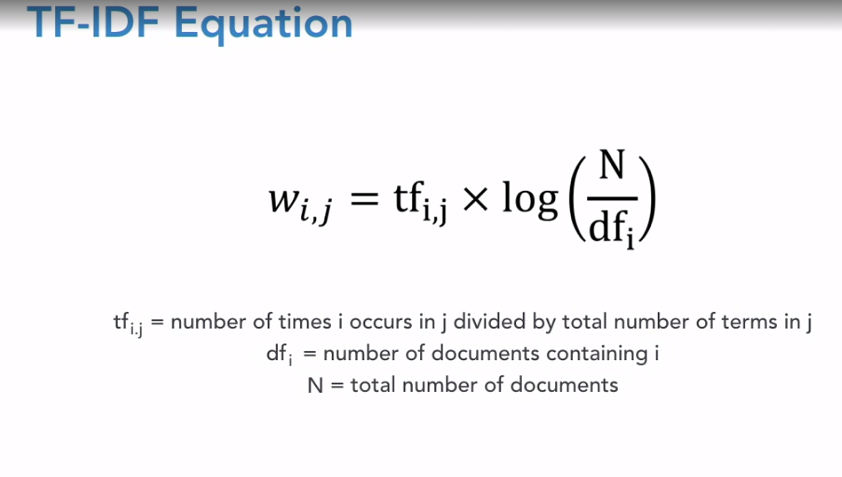

In [77]:
#Like Count vectorizer, the TfidfVectorizer requires tokens as input. 
#So I will pass the text along with the pre-processing function token_text() created previously for Count Vectorizer


#instantiate if you have a  cleaning function you want to run before the count vector pass it as 
# analyzer = function name 
tfidf_vect = TfidfVectorizer(analyzer = token_text)
    
X_counts = tfidf_vect.fit_transform(df['text_body'])
print(X_counts.shape)
print(tfidf_vect.get_feature_names_out())

(5570, 8337)
['' '0' '008704050406' ... 'ü' 'üll' '〨ud']


In [78]:
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.head()
X_counts_df.columns = tfidf_vect.get_feature_names_out() 
X_counts_df.head()

#Tip - In the vectorization step we are creating features from the text that represents indiviual words or combinations (in case of Ngrams). 
# These 3 types of vectorization methods can also be combined to create new features. 
# For example, we can create Ngrams and then pass Ngram tokens to TfidfVectorizer to get TF-IDF term frequency for Ngrams

,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering 
For creating the ML classification model, we will use the TF-IDF term frequency for each token - i.e. the 8337 features we got from TfidfVectorizer

There are additional features we can create from the SMS text like length of the text and % of punctuations in the text that may be good indicators of spam. 
In following code we will create these features and explore descriptive statistics and relation with Spam vs Ham SMSs. 

In [79]:
#create length of characters in a sentance excluding white space 

df['len'] = df['text_body'].apply(lambda x: len(x) - x.count(" "))
df.head()

,label,text_body,text_clean,token,token_no_stopwords,token_stemmed,clean_txt_for_Ngram,len
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr...",ive search right word thank breather I promis ...,160
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri 2 wkli comp win FA cup final tkt 21...,128
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",nah I dont think goe usf live around though,49
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,...",even brother like speak they treat like aid pa...,62
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]",I have A date ON sunday with will,28


In [80]:
#create new metric which tells the % of punctuations in given text 

#hypothesis -- may be spam msg has more punctuations 

def count_punct(text): 
    count = sum([1 for char in text if char in string.punctuation])
    return  round(count/(len(text) - text.count(" ")),3)*100

df['pct punct'] = df['text_body'].apply(lambda x: count_punct(x))
df.head()

,label,text_body,text_clean,token,token_no_stopwords,token_stemmed,clean_txt_for_Ngram,len,pct punct
0,ham,I've been searching for the right words to tha...,Ive been searching for the right words to than...,"[ive, been, searching, for, the, right, words,...","[ive, searching, right, words, thank, breather...","[ive, search, right, word, thank, breather, pr...",ive search right word thank breather I promis ...,160,2.5
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri 2 wkli comp win FA cup final tkt 21...,128,4.7
2,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho...",nah I dont think goe usf live around though,49,4.1
3,ham,Even my brother is not like to speak with me. ...,Even my brother is not like to speak with me T...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids...","[even, brother, like, speak, treat, like, aid,...",even brother like speak they treat like aid pa...,62,3.2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,I HAVE A DATE ON SUNDAY WITH WILL,"[i, have, a, date, on, sunday, with, will]","[date, sunday]","[date, sunday]",I have A date ON sunday with will,28,7.1


In [81]:
#descriptive statistics 
df.groupby('label')[['len', 'pct punct']].describe()

#observation 
# - spam messages seem to be lengthy. we will explore the distribution of SMS having length between 0 and 200. Most of the SMSs lie in this range 
# - On an average spam messages have less % of punctuations than ham messages 


len                                                          \
        count       mean        std   min    25%    50%    75%    max   
label                                                                   
ham    4824.0   58.04830  46.986646   2.0   27.0   43.0   75.0  740.0   
spam    746.0  115.72252  24.062937  12.0  109.0  124.0  131.0  190.0   

      pct punct                                                     
          count      mean       std  min    25%  50%    75%    max  
label                                                               
ham      4824.0  7.468802  6.980199  0.0  3.400  5.7  9.700  100.0  
spam      746.0  4.889008  2.778515  0.0  2.925  4.7  6.475   20.7

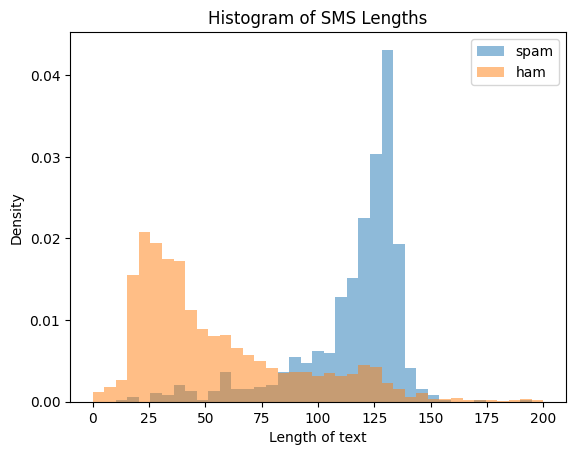

In [82]:
#feature evaluation 

%matplotlib inline 

#creates an array of 40 equally spaced values between 0 and 200 (inclusive). These values represent the edges of the bins for your histogram.
bins = np.linspace(0,200,40)

#binning in range of 0 to 200 will put both ham and spam at same scale. we have way more ham records so ham histogram will dwraf the spam one and it will 
#be hard to spot the difference 
pyplot.hist(df[df['label'] == 'spam']['len'], bins, alpha = 0.5 , density=True, label ='spam')

pyplot.hist(df[df['label'] == 'ham']['len'], bins, alpha = 0.5 , density=True, label ='ham')

# Add labels and legend
pyplot.xlabel("Length of text")
pyplot.ylabel("Density")
pyplot.title("Histogram of SMS Lengths")
pyplot.legend()

# Show the plot
pyplot.show()

#observation - the distribution of length of SMS varies or spam vs ham suggesting that this is a good candidate feature for prediction 

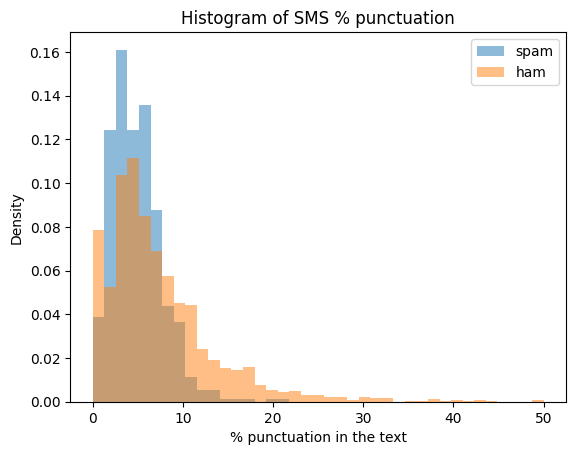

In [83]:

#explore distribution of % punctuation 

bins = np.linspace(0,50,40)

pyplot.hist(df[df['label'] == 'spam']['pct punct'], bins, alpha = 0.5 , density=True, label ='spam')
# pyplot.hist()
pyplot.hist(df[df['label'] == 'ham']['pct punct'], bins, alpha = 0.5 , density=True, label ='ham')

# Add labels and legend
pyplot.xlabel("% punctuation in the text")
pyplot.ylabel("Density")
pyplot.title("Histogram of SMS % punctuation")
pyplot.legend()

# Show the plot
pyplot.show()

#observation - there is not a lot of difference in the distribution 

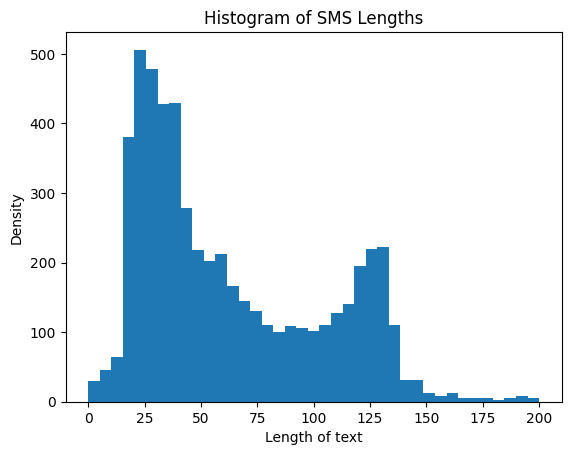

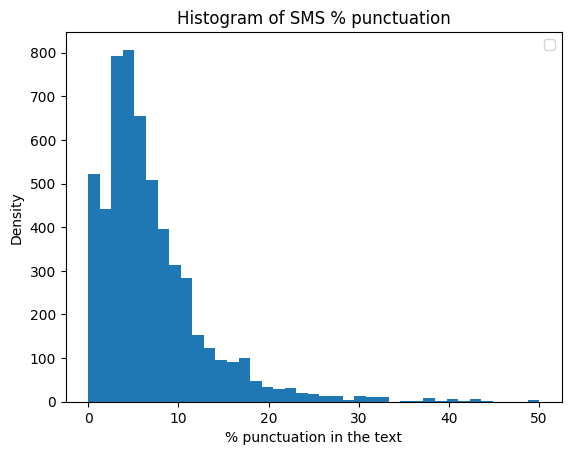

In [84]:
#check overall feature distribution to see if there is extreme skewness which requires data to be transformed 

bins = np.linspace(0,200,40)
pyplot.hist(df['len'], bins)
pyplot.xlabel("Length of text")
pyplot.ylabel("Density")
pyplot.title("Histogram of SMS Lengths")
pyplot.show()


bins = np.linspace(0,50,40)
pyplot.hist(df['pct punct'], bins)
pyplot.xlabel("% punctuation in the text")
pyplot.ylabel("Density")
pyplot.title("Histogram of SMS % punctuation")
pyplot.legend()
pyplot.show()
# since pct punct is skewed we need to apply box-cox transformation to get normally distributed values 


power range for transformation typically used -2 to 2 

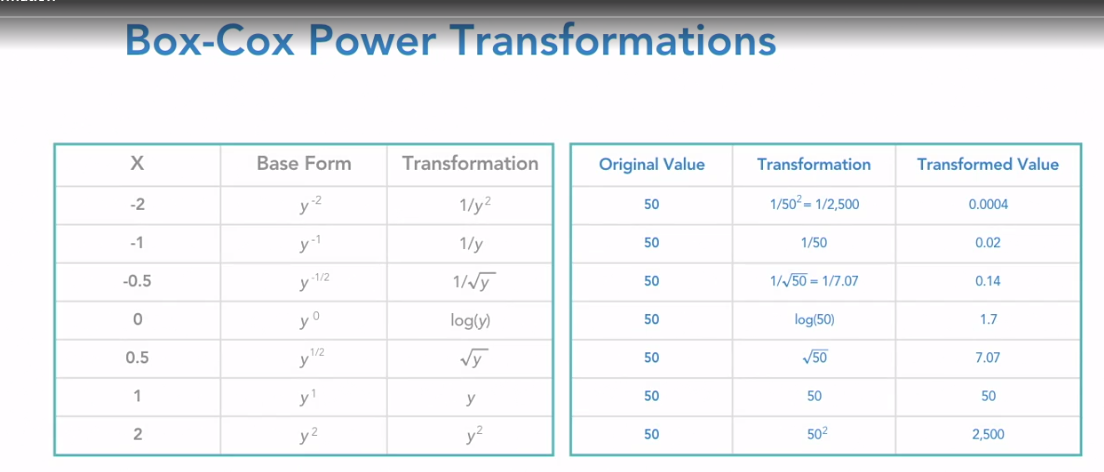
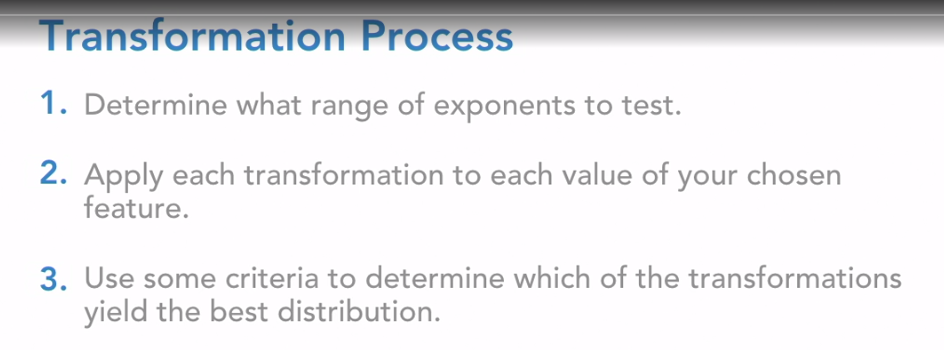

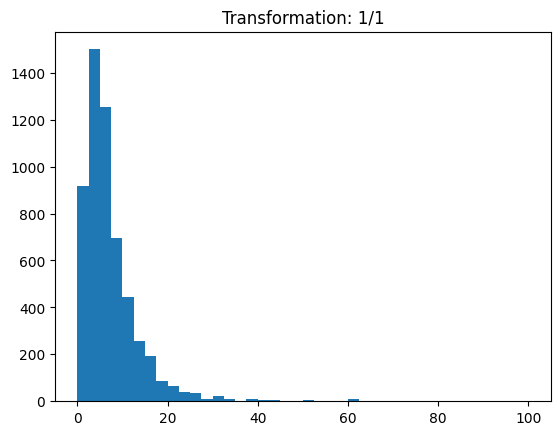

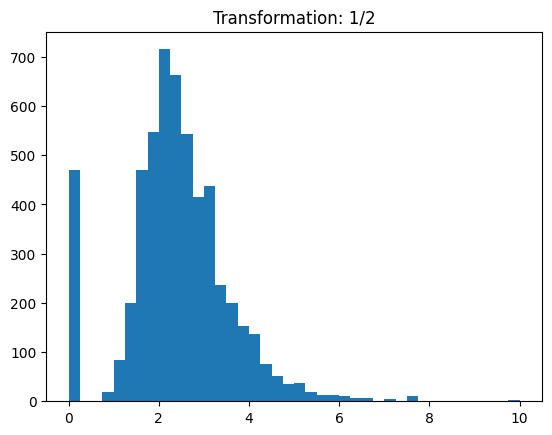

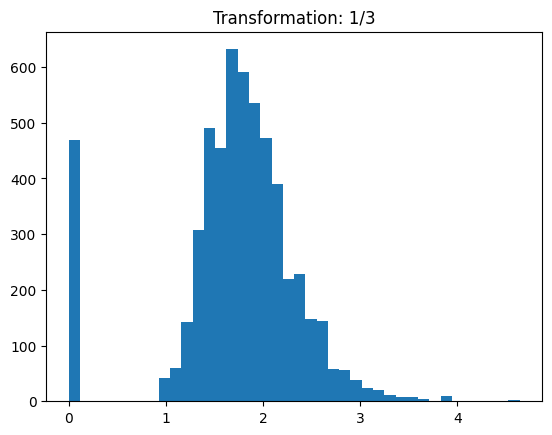

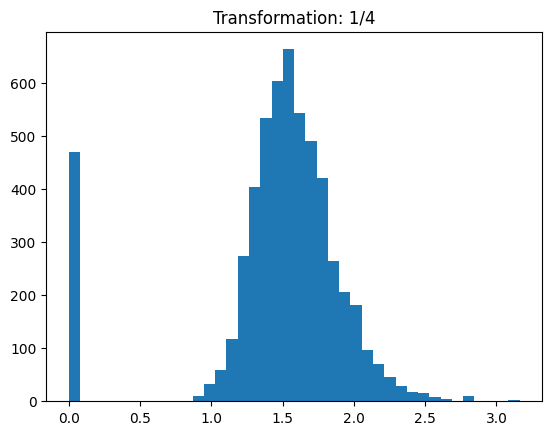

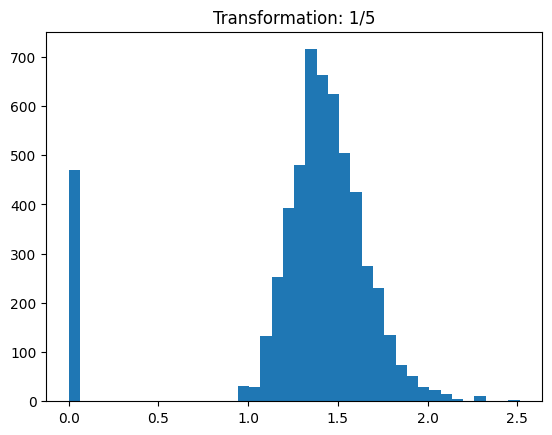

In [85]:
#we will test a range of power transformation and evaluate the density plots to find a suitable transformation that gives normal distribution 
for i in [1,2,3,4,5]: 
    pyplot.hist((df['pct punct'])**(1/i), bins = 40)
    pyplot.title('Transformation: 1/{}'.format(str(i)))
    pyplot.show()
    
    #as per the plots below we can choose power transformation of 1/4 or 1/5 as they give pretty normal distribution 
#     we see a stack for 0 that is for records where there are no punctuations. We will let it be in model data set 

# Building Binary Classification Model 

We will use the length of SMS, % of punctuations and text features created using TfidfVectorizer to build the predictive model. Reminder, this gives inverse document frequency which is weight of the word based on its frequency in the document and the given text. 

Goal is to predict if a SMS is spam. 

We will use following metrics to evaluate the model 
- Accuracy = # SMS predicted correctly/ total number of SMSs 
- Precision = #predicted as spam that are actually spam/ total # of predicted as spam i.e True Positive/(True Positive + False Positive)  
- Recall = #predicted as spam that are actually spam/total # of SMS that are actually spam  i.e. True Positive/(True Positive + False Negative) 

Tip - If false positve are very costly then optimize model for precision 

If false negative are very costly thn optimizae for recall 


In [86]:
#Implementing random forest algorithm for the demo
# Print the default hyperparameters of Random Forest Classifier 
rf = RandomForestClassifier()
print(f"Number of trees in the forest (n_estimators): {rf.n_estimators}")
print(f"Max number of features considered for splitting a node (max_features): {rf.max_features}")
print(f"Max number of levels in each decision tree (max_depth): {rf.max_depth}")
print(f"Min number of data points placed in a node before the node is split (min_samples_split): {rf.min_samples_split}")
rf = RandomForestClassifier(n_jobs = -1) #setting to -1 t parallel process multiple decision trees

Number of trees in the forest (n_estimators): 100
Max number of features considered for splitting a node (max_features): sqrt
Max number of levels in each decision tree (max_depth): None
Min number of data points placed in a node before the node is split (min_samples_split): 2


In [87]:
#run with train test split 

#create binary variable to predict spam 
df['Is_spam'] = df['label'].map({'spam': 1, 'ham': 0})

#correct way to prepare data for modelling is to first split into train and test and then vectorize  
#This ensures that the model learns from the training data without any information leakage from the test data. 

x_train, x_test, y_train, y_test = train_test_split(df[['text_body', 'len', 'pct punct']], df['Is_spam'], test_size = 0.2)

#vectorize data 
tfidf_vect = TfidfVectorizer(analyzer = token_text)
#create a vectorization based on training data 
tfidf_vect_fit = tfidf_vect.fit(x_train['text_body'])

#apply this vectorization to train and test data 
#basically the features i.e. the tokens from only training set are considered for vectorization. IF a word appears only in test set there will be no token for it as a feature 
#in below transformation set the Inverse doc frequency will be calculated for these tokens 

tfidf_train = tfidf_vect_fit.transform(x_train['text_body'])
tfidf_test = tfidf_vect_fit.transform(x_test['text_body'])

#now concatenate the len and % punctuation features with TF-IDF matrix
X_train = pd.concat([x_train[['len', 'pct punct']].reset_index(drop = True),
          pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vect_fit.get_feature_names_out() )],axis=1
         )

X_train.head()

X_test = pd.concat([x_test[['len', 'pct punct']].reset_index(drop = True),
          pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vect_fit.get_feature_names_out() )],axis=1
         )

X_test.head()





,len,pct punct,,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,...,zoe,zogtoriu,zoom,zouk,zyada,Ü,é,ü,üll,〨ud
0,67,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,72,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
#fit Random Forest Classifier on training data 

rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, n_jobs = -1)
rf_model = rf.fit(X_train, y_train)

In [89]:
#get feature importance -- print top 10 features 
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse = True) [0:10]
    
#observation - 
# - keywords/ tokens like call, free, mobil, claim, prize are top indicators of spam. It makes intuitive sense as we usually see spams related to free offers or mentioning urgency 
# - The text length feature, len, is also a key feature. As we have seen in descriptive analysis, spam messages are lengthier comparatively 

[(0.04544585084327906, 'len'),
 (0.044490715682472225, 'txt'),
 (0.02567923363121372, 'claim'),
 (0.023577608207785424, 'call'),
 (0.02262138893728527, 'prize'),
 (0.021855853419440473, 'mobil'),
 (0.018160594059609403, 'tone'),
 (0.016612067479116078, 'award'),
 (0.01552930244215815, 'servic'),
 (0.015337469329182158, 'To')]

In [90]:
#evaluate model performance on test data 

y_pred = rf_model.predict(X_test)
#pos label means positive label - which means what we are interested in predicting. We want to predict spam

#evaluation metric on test set 

precision , recall, fscore, support = score(y_test, y_pred, pos_label = 1, average='binary')

print(f'precision on test set {precision}')
print(f'recall on test set {recall}')
print(f'F1 score on test set {fscore}')

#As seen earlier in data exploration, we only have 13% spam records which means we are dealing with a class imbalance problem where spam is the minority class 
#keeping this in mind, we will evaluate the model using F1 score which is a harmonic mean of precision and recall, balancing both metrics.

# There are various ways to further create a better performing model and improve the F1 score
# - We can address class imbalance using techniques likes Oversampling, Undersampling, Synthetic Minority Oversampling Technique (SMOTE)
# reference - https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/
# - Using ensemble method 
# - Hyperparameter tuning 
# - Stratified cross validation - ensure that each fold has balanced representation of both classes. similarly we can also do stratified train test split 



precision on test set 1.0
recall on test set 0.6054421768707483
F1 score on test set 0.7542372881355932


In [91]:
#let us enhance the random forest model using stratified train test split and setting the random forest model parameter class_weight = balanced 
x_train, x_test, y_train, y_test = train_test_split(df[['text_body', 'len', 'pct punct']], df['Is_spam'], test_size = 0.2, stratify = df['Is_spam'])

#vectorize data 
tfidf_vect = TfidfVectorizer(analyzer = token_text)
#create a vectorization based on training data 
tfidf_vect_fit = tfidf_vect.fit(x_train['text_body'])

#apply this vectorization to train and test data 
#basically the features i.e. the tokens from only training set are considered for vectorization. IF a word appears only in test set there will be no token for it as a feature 
#in below transformation set the Inverse doc frequency will be calculated for these tokens 

tfidf_train = tfidf_vect_fit.transform(x_train['text_body'])
tfidf_test = tfidf_vect_fit.transform(x_test['text_body'])

#now concatenate the len and % punctuation features with TF-IDF matrix
X_train = pd.concat([x_train[['len', 'pct punct']].reset_index(drop = True),
          pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vect_fit.get_feature_names_out() )],axis=1
         )

X_train.head()

X_test = pd.concat([x_test[['len', 'pct punct']].reset_index(drop = True),
          pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vect_fit.get_feature_names_out() )],axis=1
         )

X_test.head()

#fit Random Forest Classifier on training data 

rf = RandomForestClassifier(n_estimators = 50, max_depth = 20, n_jobs = -1, class_weight = 'balanced')
rf_model = rf.fit(X_train, y_train)

#evaluate model performance on test data 

y_pred = rf_model.predict(X_test)
#pos label means positive label - which means what we are interested in predicting. We want to predict spam

#evaluation metric on test set 

precision , recall, fscore, support = score(y_test, y_pred, pos_label = 1, average='binary')

print(f'precision on test set {precision}')
print(f'recall on test set {recall}')
print(f'F1 score on test set {fscore}')

#this enhancement improved the F1 score from 75% to 88% 

precision on test set 0.9924242424242424
recall on test set 0.8791946308724832
F1 score on test set 0.9323843416370107
